In [1]:
%pylab inline
from astropy.io import fits
import astropy.units as u
import pickle as pickle
import os as os
import pandas as pd

from spectools_ir.utils import extract_hitran_data, spec_convol, make_rotation_diagram, get_molmass
from spectools_ir.utils import compute_thermal_velocity, sigma_to_fwhm, fwhm_to_sigma, wn_to_k, spec_convol_R
from spectools_ir.utils import get_miri_mrs_resolution, get_miri_mrs_wavelengths, make_miri_mrs_figure

from spectools_ir.flux_calculator import calc_fluxes, make_lineshape

from spectools_ir.slabspec import make_spec

from spectools_ir.slab_fitter import Config, LineData,Retrieval
from spectools_ir.slab_fitter import corner_plot, trace_plot, find_best_fit, compute_model_fluxes
from spectools_ir.slab_fitter import calc_solid_angle, calc_radius
from spectools_ir.slab_fitter import read_data_from_file, get_samples

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import spectools_ir
print(spectools_ir.__file__)

/Users/belaarwen/opt/anaconda3/lib/python3.9/site-packages/spectools_ir/__init__.py


In [3]:
hitran_data_CO=extract_hitran_data('CO',4.6,5.42,vup=1)                     #calling for CO lines
hitran_data_H2O=extract_hitran_data('H2O',4.6,5.42,eupmax=4000,aupmin=0)    #calling for H2O lines 
                                                                            #eupmax gives a maximum to the energy transition in ___?
                                                                            #aupmin gives __?__

#This line calls to the hitran dataset and labels an astropy table as "hitran_data". 
#We are calling for CO and H2O from the 5.3 to the 5.42 micron regime 

In [4]:
extract_hitran_data

<function spectools_ir.utils.utils.extract_hitran_data(molecule_name, wavemin, wavemax, isotopologue_number=1, eupmax=None, aupmin=None, swmin=None, vup=None)>

In [5]:
sources_list = ['CITau','FZTau','IQTau']    #3 sources with the new regime
#sources_list = ['AS205','CITau','DoAr25','DoAr33','FZTau','GKTau','HD143006','HPTau','IQTau','IRAS04385','WSB52'] #all 11 sources, some without the new regime

TypeError: '>' not supported between instances of 'tuple' and 'float'

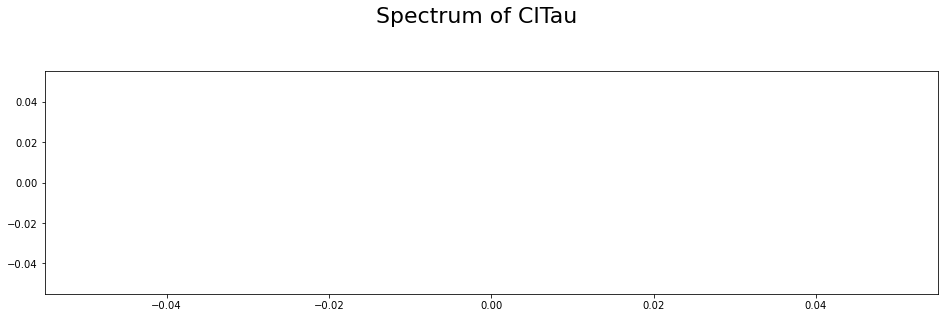

In [6]:
for i in sources_list:
    infile  = '/Users/belaarwen/Desktop/Vassar/Astronomy/Thesis/reducs22/'+i+'_orders.fits'
    hdulist = fits.open(infile)      #hdu means header data unit so we are creating a list of header data units to use in further files
    data    = hdulist[1].data
    wave    = data['wave'][0]
    flux    = data['flux'][0]
    
    fig = plt.figure(figsize = (16,9))
    fig.suptitle('Spectrum of ' +i, fontsize = 22)

    ax1 = fig.add_subplot(211)
    ax1.plot(wave,flux)
    #ax1.set_xlim(4.64, 4.78)
    for λ in enumerate(hitran_data_CO['wave']):
        if((λ>4.64) & (λ<4.83)):
            ax1.axvline(λ, color='C1') 
    for λ in enumerate(hitran_data_H2O['wave']):
        if((λ>4.64) & (λ<4.83)):
            ax1.axvline(λ, color='C2') 
    ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
    ax1.set_ylabel('Flux [Jy]', fontsize=14)
    
    ax2 = fig.add_subplot(212)
    ax2.plot(wave,flux)
    ax2.set_xlim(4.78, 5.3)
    for λ in enumerate(hitran_data_CO['wave']):
        if((λ>4.83) & (λ<5.3)):
            ax1.axvline(λ, color='C1') 
    for λ in enumerate(hitran_data_H2O['wave']):
        if((λ>4.83) & (λ<5.3)):
            ax1.axvline(λ, color='C2')         
    ax2.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
    ax2.set_ylabel('Flux [Jy]', fontsize=14)
    


In [ ]:
data